C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Epoch 1/100


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0239 - val_loss: 0.0080
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - val_l

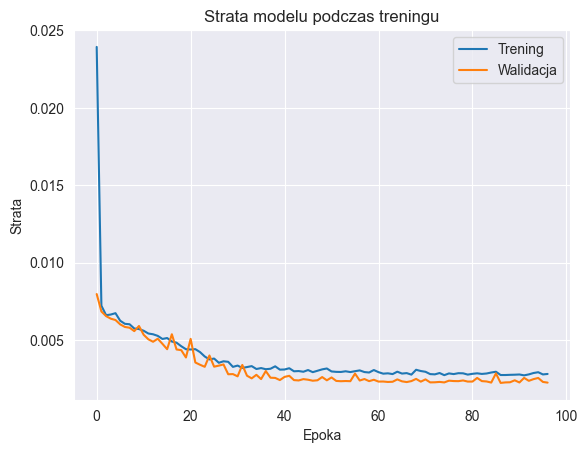

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


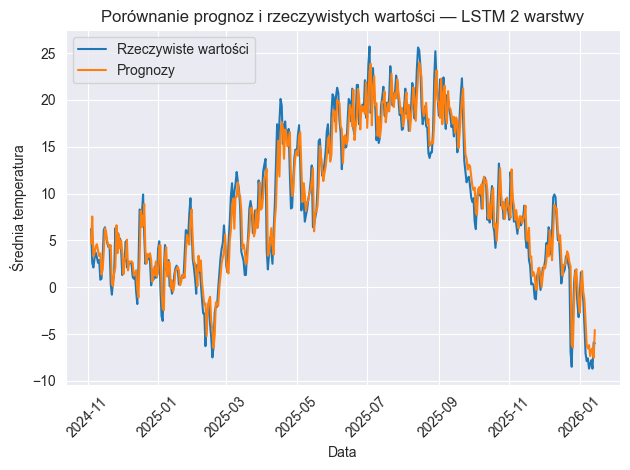

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# =========================
# Wczytanie i przygotowanie danych
# =========================
df = pd.read_csv(
    "european_capitals_history_clean2.csv",
    parse_dates=["time"]
)

df_city = df[df['city'] == 'Warszawa']
df_city = df_city[['time', 'city', 'temp']]
df_city.sort_values(by=["time"], inplace=True)

# =========================
# Tworzenie sekwencji czasowych
# =========================

def create_sequences(df, window=20):  # <- zmienione z 5 na 10
    sequences = []
    labels = []
    for i in range(len(df) - window):
        seq = df.iloc[i:i + window]['temp'].values
        label = df.iloc[i + window]['temp']
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Tworzenie sekwencji z nowym window
sequences, labels = create_sequences(df_city, window=20)

# =========================
# Normalizacja danych
# =========================
scaler = MinMaxScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)
labels_scaled = scaler.transform(labels.reshape(-1, 1))
sequences_scaled = sequences_scaled.reshape((sequences_scaled.shape[0], sequences_scaled.shape[1], 1))

# =========================
# Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(sequences_scaled) * 0.8)
X_train = sequences_scaled[:train_size]
X_test  = sequences_scaled[train_size:]
y_train = labels_scaled[:train_size]
y_test  = labels_scaled[train_size:]

# =========================
# Budowa modelu LSTM z dwiema warstwami
# =========================
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# =========================
# EarlyStopping
# =========================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# =========================
# Trenowanie modelu
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=100,           # można zwiększyć liczbę epok, EarlyStopping zatrzyma trening wcześniej
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# =========================
# Zapis modelu
# =========================
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lstm_warszawa_2layers.keras")
model.save(model_path)
print(f"Model zapisany w: {model_path}")

# =========================
# Wizualizacja straty
# =========================
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.legend()
plt.title("Strata modelu podczas treningu")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.show()

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.plot(df_city['time'].iloc[-len(y_test_rescaled):], y_test_rescaled, label='Rzeczywiste wartości')
plt.plot(df_city['time'].iloc[-len(predictions_rescaled):], predictions_rescaled, label='Prognozy')
plt.legend()
plt.title("Porównanie prognoz i rzeczywistych wartości — LSTM 2 warstwy")
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# =========================
# Funkcja budująca model LSTM z 2 warstwami i Dropout
# =========================
def build_lstm_model(input_shape):
    model = Sequential()
    # Pierwsza warstwa LSTM zwracająca sekwencję
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    # Druga warstwa LSTM zwracająca tylko ostatnią wartość
    model.add(LSTM(units=32, return_sequences=False))
    # Warstwa wyjściowa
    model.add(Dense(1))
    # Kompilacja
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# =========================
# Time Series Cross-Validation
# =========================
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores  = []
mse_scores  = []
r2_scores   = []

fold = 1

for train_index, test_index in tscv.split(sequences_scaled):
    print(f"\nFold {fold}")

    X_train = sequences_scaled[train_index]
    X_test  = sequences_scaled[test_index]

    y_train = labels_scaled[train_index]
    y_test  = labels_scaled[test_index]

    model = build_lstm_model(input_shape=(X_train.shape[1], 1))

    # =========================
    # EarlyStopping
    # =========================
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model.fit(
        X_train,
        y_train,
        epochs=100,           # EarlyStopping zatrzyma trening wcześniej
        batch_size=32,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        shuffle=False
    )

    y_pred = model.predict(X_test)

    # Odwrócenie skalowania
    y_test_rescaled = scaler.inverse_transform(y_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)

    mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    r2   = r2_score(y_test_rescaled, y_pred_rescaled)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(
        f"R²: {r2:.4f} | "
        f"MAE: {mae:.4f} | "
        f"MSE: {mse:.4f} | "
        f"RMSE: {rmse:.4f}"
    )

    fold += 1

# =========================
# Podsumowanie wyników
# =========================
print("\nWalk-Forward Cross-Validation — LSTM (2 warstwy + EarlyStopping)")
print(f"R²   : {np.mean(r2_scores):.4f}")
print(f"MAE  : {np.mean(mae_scores):.4f}")
print(f"MSE  : {np.mean(mse_scores):.4f}")
print(f"RMSE : {np.mean(rmse_scores):.4f}")



Fold 1


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R²: 0.8033 | MAE: 3.0104 | MSE: 14.4325 | RMSE: 3.7990

Fold 2


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
R²: 0.9182 | MAE: 1.7543 | MSE: 5.0437 | RMSE: 2.2458

Fold 3


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R²: 0.9197 | MAE: 1.8886 | MSE: 5.7988 | RMSE: 2.4081

Fold 4


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R²: 0.9281 | MAE: 1.6796 | MSE: 4.5894 | RMSE: 2.1423

Fold 5


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
R²: 0.9258 | MAE: 1.7344 | MSE: 4.8483 | RMSE: 2.2019

Walk-Forward Cross-Validation — LSTM (2 warstwy + EarlyStopping)
R²   : 0.8990
MAE  : 2.0135
MSE  : 6.9425
RMSE : 2.5594


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


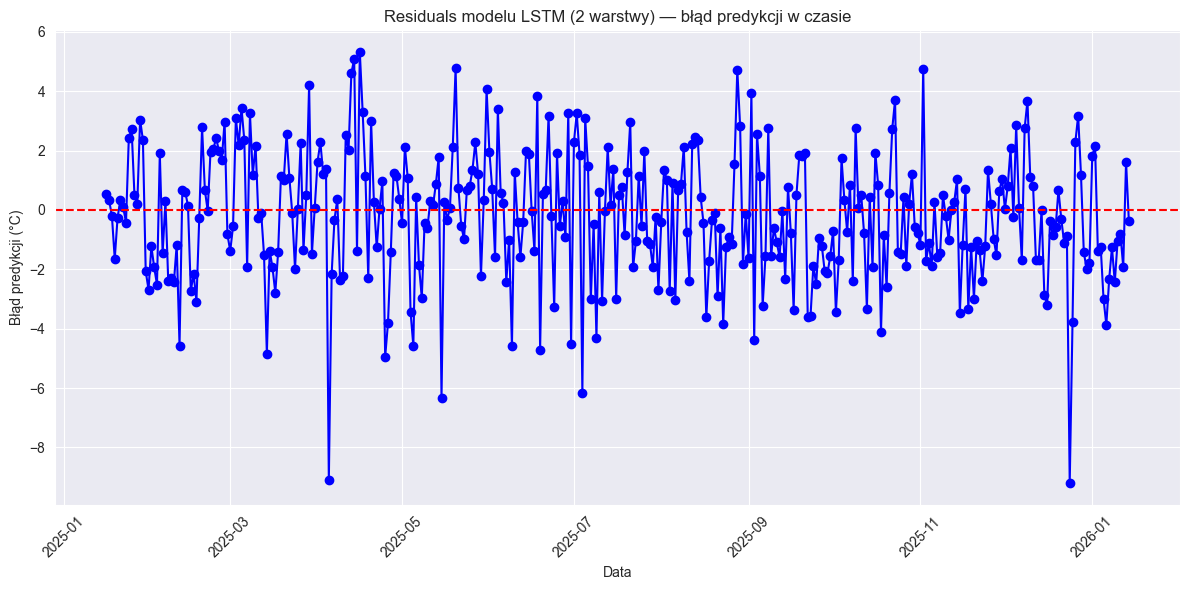

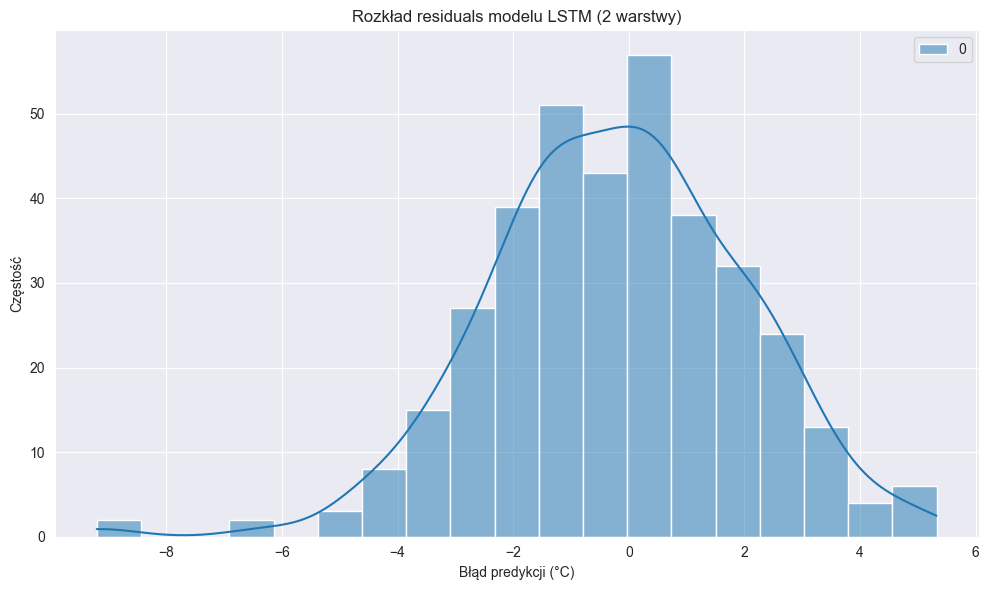

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# Predykcja na zbiorze testowym
# =========================
predictions = model.predict(X_test)

# Odwrócenie skalowania
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

# Dopasowanie długości (czasem w LSTM występuje różnica długości)
min_len = min(len(y_test_rescaled), len(predictions_rescaled))
y_test_rescaled = y_test_rescaled[:min_len]
predictions_rescaled = predictions_rescaled[:min_len]

# =========================
# Obliczenie residuals
# =========================
residuals = y_test_rescaled - predictions_rescaled

# =========================
# Wykres residuals w czasie
# =========================
plt.figure(figsize=(12,6))
plt.plot(
    df_city['time'].iloc[-len(residuals):],
    residuals,
    marker='o',
    linestyle='-',
    color='b'
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals modelu LSTM (2 warstwy) — błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd predykcji (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Histogram residuals
# =========================
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='b')
plt.title('Rozkład residuals modelu LSTM (2 warstwy)')
plt.xlabel('Błąd predykcji (°C)')
plt.ylabel('Częstość')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/100


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0573 - val_loss: 0.0119
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - val_loss: 0.0090
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 0.0091
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0096
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0083 - val_loss: 0.0087
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0088
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0083
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0088
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_l

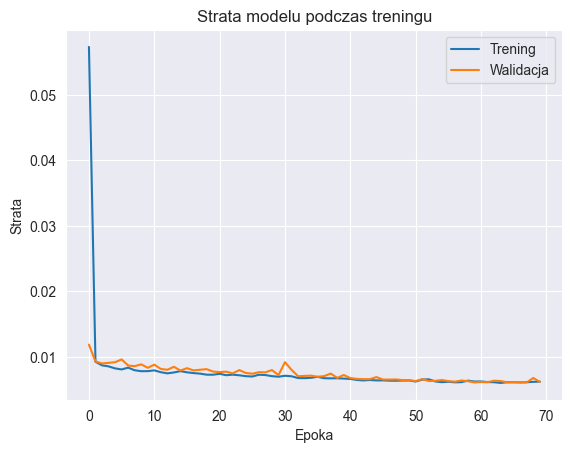

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


ValueError: x and y must have same first dimension, but have shapes (436,) and (2180,)

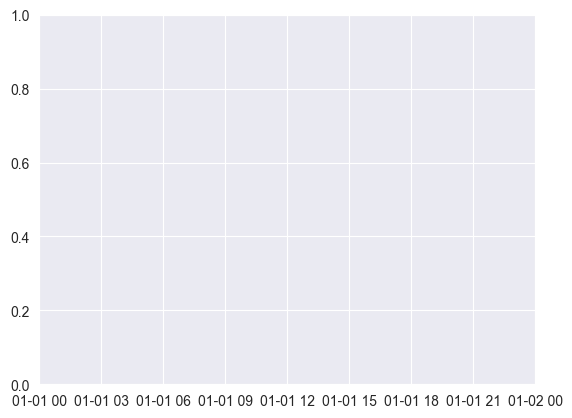

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'][['time', 'temp']]
df_city.sort_values(by="time", inplace=True)

# =========================
# 2. Tworzenie sekwencji z multi-step output
# =========================
def create_sequences(df, window=20, forecast_horizon=5):
    X, y = [], []
    for i in range(len(df) - window - forecast_horizon + 1):
        X.append(df.iloc[i:i+window]['temp'].values)
        y.append(df.iloc[i+window:i+window+forecast_horizon]['temp'].values)  # multi-step
    return np.array(X), np.array(y)

WINDOW = 20
FORECAST = 5
X, y = create_sequences(df_city, WINDOW, FORECAST)

# =========================
# 3. Normalizacja danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1,1)).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)

# LSTM wymaga [samples, timesteps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# =========================
# 4. Podział na zbiór treningowy i testowy
# =========================
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# =========================
# 5. Budowa modelu LSTM 2-warstwowego
# =========================
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(FORECAST))  # multi-step output
model.compile(optimizer='adam', loss='mean_squared_error')

# =========================
# 6. EarlyStopping
# =========================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# =========================
# 7. Trenowanie modelu
# =========================
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# =========================
# 8. Zapis modelu
# =========================
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lstm_warszawa_5days.keras")
model.save(model_path)
print(f"Model zapisany w: {model_path}")

# =========================
# 9. Wizualizacja straty
# =========================
plt.plot(history.history['loss'], label='Trening')
plt.plot(history.history['val_loss'], label='Walidacja')
plt.legend()
plt.title("Strata modelu podczas treningu")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.show()

# =========================
# 10. Predykcja na zbiorze testowym
# =========================
predictions_scaled = model.predict(X_test)
predictions_rescaled = scaler_y.inverse_transform(predictions_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)

plt.plot(df_city['time'].iloc[-len(y_test_rescaled):], y_test_rescaled.flatten(), label='Rzeczywiste wartości')
plt.plot(df_city['time'].iloc[-len(predictions_rescaled):], predictions_rescaled.flatten(), label='Prognozy')
plt.legend()
plt.title("Porównanie prognoz i rzeczywistych wartości — LSTM 2 warstwy")
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# =========================
# 11. Prognoza na 5 dni w przyszłość (ostatnia sekwencja z testu)
# =========================
future_scaled = model.predict(X_test[-1].reshape(1, WINDOW, 1))
future_pred = scaler_y.inverse_transform(future_scaled)

print("Prognozy na 5 dni do przodu (średnia temperatura):")
print(future_pred.flatten())
